In [30]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import lightgbm as lgb
from catboost import CatBoostRegressor
from tqdm import tqdm_notebook
from itertools import product

In [31]:
import os
input_folder = "../predict_future_sales" # or input_folder = os.getcwd()
file_names = (os.listdir(input_folder))

In [32]:
file_names

['.ipynb_checkpoints',
 '1.feather',
 'benchmark.ipynb',
 'city_name_eng.csv',
 'city_name_rus.csv',
 'coordinates.csv',
 'EDA.ipynb',
 'feature generation.ipynb',
 'geocoding_and_ translation.ipynb',
 'GoogleNews-vectors-negative300.bin.gz',
 'hol.feather',
 'itc_en.feather',
 'itc_en_with_word_embed.feather',
 'items.csv',
 'item_categories.csv',
 'it_en.feather',
 'it_en_with_word_embed.feather',
 'learn_error.tsv',
 'meta.tsv',
 'predict_future_sales.ipynb',
 'predict_future_sales_with_text_features.ipynb',
 'Programming_assignment_week_4 (1).ipynb',
 'references.txt',
 'sales_train.csv.gz',
 'sales_train_v2.csv',
 'sample_submission.csv',
 'sample_submission.csv.gz',
 'sample_submission1.csv',
 'shops.csv',
 'shops_city_longitude_latitude_en.csv',
 'sh_en.feather',
 'test.csv',
 'test.csv.gz',
 'time_left.tsv',
 'train']

In [33]:
sales_train = pd.read_csv('sales_train.csv.gz')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
sample_sub = pd.read_csv('sample_submission.csv.gz')
test = pd.read_csv('test.csv.gz')

In [34]:
import feather
import pyarrow
hol = pyarrow.feather.read_feather('hol.feather')
it_en = pyarrow.feather.read_feather('it_en.feather')
itc_en = pyarrow.feather.read_feather('itc_en.feather')
sh_en = pyarrow.feather.read_feather('sh_en.feather')
coordinates = pd.read_csv('coordinates.csv')
city_name_eng = pd.read_csv('city_name_eng.csv')
it_en_with_word_embed = pyarrow.feather.read_feather('it_en_with_word_embed.feather')
itc_en_with_word_embed = pyarrow.feather.read_feather('itc_en_with_word_embed.feather')

In [ ]:
it_en.head()

In [ ]:
itc_en.head()

In [ ]:
items.head()

In [ ]:
coordinates

In [ ]:
sh_en.head

In [ ]:
shops.head()

In [ ]:
sample_sub.head()

In [35]:
test['item_cnt_day'] = -1
test['date_block_num'] = 34
sales_train['ID'] = 999

In [ ]:
test.head()

In [ ]:
sales_train.head()

In [146]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID
0,02.01.2013,0,59,22154,999.00,1.0,999
1,03.01.2013,0,25,2552,899.00,1.0,999
2,05.01.2013,0,25,2552,899.00,-1.0,999
3,06.01.2013,0,25,2554,1709.05,1.0,999
4,15.01.2013,0,25,2555,1099.00,1.0,999


In [36]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                `float64` type to `float32`
                `int64`   type to `int32`
    '''

    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
 
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [37]:
sales = sales_train[['ID','date_block_num','shop_id','item_id','item_cnt_day']]
test = test[['ID','date_block_num','shop_id','item_id','item_cnt_day']]
sales = pd.concat([sales, test])
# sales = sales[sales['shop_id'].isin([26, 27, 28])]

In [38]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [168]:
all_data.tail()

,shop_id,item_id,date_block_num,target,target_shop,target_item
11128045,45,18454,34,-1.0,-5100.0,-42.0
11128046,45,16188,34,-1.0,-5100.0,-42.0
11128047,45,15757,34,-1.0,-5100.0,-42.0
11128048,45,19648,34,-1.0,-5100.0,-42.0
11128049,45,969,34,-1.0,-5100.0,-42.0


In [39]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

In [55]:
to_drop_cols

['target_shop', 'target_item', 'target', 'date_block_num']

In [12]:
all_data.tail()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
6639289,45,18454,34,-1.0,-5100.0,-42.0,1.0,2.0,702.0,0.0,...,0.0,12.0,675.0,0.0,19.0,622.0,0.0,0.0,0.0,55
6639290,45,16188,34,-1.0,-5100.0,-42.0,0.0,1.0,702.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64
6639291,45,15757,34,-1.0,-5100.0,-42.0,0.0,5.0,702.0,0.0,...,0.0,4.0,675.0,0.0,8.0,622.0,0.0,9.0,1251.0,55
6639292,45,19648,34,-1.0,-5100.0,-42.0,0.0,2.0,702.0,0.0,...,0.0,2.0,675.0,0.0,4.0,622.0,0.0,0.0,0.0,40
6639293,45,969,34,-1.0,-5100.0,-42.0,0.0,3.0,702.0,0.0,...,0.0,2.0,675.0,0.0,2.0,622.0,0.0,6.0,1251.0,37


In [41]:
it_en_with_word_embed.iloc[:,4:] = it_en_with_word_embed.iloc[:,4:].astype(np.float16)
itc_en_with_word_embed.iloc[:,3:] = itc_en_with_word_embed.iloc[:,3:].astype(np.float16)

In [42]:
# Add text features
all_data = all_data.merge(it_en_with_word_embed[['it_id','itc_id']], left_on='item_id', right_on='it_id', how='left').drop(labels =['it_id'],axis=1) # add itc_id

In [43]:
gc.collect()

42

In [44]:
all_data = all_data.merge(it_en_with_word_embed.drop(labels=['itc_id','en_it_name'],axis=1).iloc[:,1:], left_on='item_id', right_on='it_id', how='left').drop(labels =['it_id'],axis=1) # add item word embedding features 

In [45]:
gc.collect()

28

In [46]:
all_data.shape

(6639294, 626)

In [47]:
all_data = all_data.merge(itc_en_with_word_embed.drop(labels=['en_itc_name'],axis=1).iloc[:,1:], left_on='itc_id', right_on='itc_id', how='left') # add item category word embedding features 

In [48]:
gc.collect()

28

In [50]:
sub_test_data = all_data[all_data['date_block_num']==34].drop(to_drop_cols, axis=1)
all_data = all_data[all_data['date_block_num']!=34]

In [56]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [57]:
# pyarrow.feather.write_feather(all_data,'all_data_no_sub_test.feather')

In [61]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

In [62]:
all_data['target'] = all_data['target'].clip(0,20)

In [74]:
6186922-6425094

-238172

In [71]:
all_data['date_block_num'].shape

(6425094,)

In [ ]:
X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)

In [ ]:
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

In [58]:
y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

MemoryError: 

# Linear Regression

In [19]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test.clip(0,20), pred_lr.clip(0,20)))

Test R-squared for linreg is 0.146042


In [23]:
print(np.sqrt((sum((y_test.clip(0,20)-pred_lr.clip(0,20))**2))/(y_test.shape[0])))
print(np.sqrt((sum((y_train.clip(0,20)-lr.predict(X_train).clip(0,20))**2))/(y_train.shape[0])))

1.049918661908493
1.0493949987899915


In [22]:
sub_pred_lr = lr.predict(sub_test_data.values)

ValueError: Found array with 0 sample(s) (shape=(0, 21)) while a minimum of 1 is required.

# Random Forest

In [51]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=0, n_jobs = -1, verbose=1)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [52]:
pred_rf = clf.predict(X_test)

In [53]:
print('Test R-squared for rf is %f' % r2_score(y_test.clip(0,20), pred_rf.clip(0,20)))
print(np.sqrt((sum((y_test.clip(0,20)-pred_rf.clip(0,20))**2))/(y_test.shape[0])))
print(np.sqrt((sum((y_train.clip(0,20)-clf.predict(X_train).clip(0,20))**2))/(y_train.shape[0])))

Test R-squared for rf is 0.254873
0.9807371321492697
0.9381757394915309


In [ ]:
sub_pred_rf = clf.predict(sub_test_data)

# Benchmark: Mean 

In [48]:
pred_mean =  np.full((238172,), np.mean(y_train))
print('Test R-squared for rf is %f' % r2_score(y_test.clip(0,20), pred_mean.clip(0,20)))
print(np.sqrt((sum((y_test.clip(0,20)-pred_mean.clip(0,20))**2))/(y_test.shape[0])))

Test R-squared for rf is -0.000711
1.136558396230848


# Light gbm

In [24]:
lgb_params = {
               'feature_fraction': 0.45,
               'metric': 'rmse',
               'nthread':11, 
               'min_data_in_leaf': 2**4, 
               'bagging_fraction': 0.84, 
               'learning_rate': 0.122, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**6,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test.clip(0,20), pred_lgb.clip(0,20)))

Test R-squared for LightGBM is 0.352241


In [25]:
print(np.sqrt((sum((y_test.clip(0,20)-pred_lgb.clip(0,20))**2))/(y_test.shape[0])))
print(np.sqrt((sum((y_train.clip(0,20)-model.predict(X_train).clip(0,20))**2))/(y_train.shape[0])))

0.9144167633545289
0.8168128467909939


In [ ]:
0.352241
0.914416763355
0.816812846791

In [ ]:
sub_pred_lgb = model.predict(sub_test_data)

# Catboost

In [54]:
from catboost import CatBoostRegressor
cat_features = [0,1,20]
cb = CatBoostRegressor(iterations=20, learning_rate=0.3, depth=3, thread_count=11)
cb.fit(X_train, y_train, cat_features)

0:	learn: 1.1029154	total: 2.16s	remaining: 41s
1:	learn: 1.0294724	total: 3.9s	remaining: 35.1s
2:	learn: 0.9857883	total: 5.57s	remaining: 31.6s
3:	learn: 0.9552109	total: 7.28s	remaining: 29.1s
4:	learn: 0.9371892	total: 9.27s	remaining: 27.8s
5:	learn: 0.9186031	total: 11s	remaining: 25.8s
6:	learn: 0.9091894	total: 13.1s	remaining: 24.4s
7:	learn: 0.9019890	total: 15s	remaining: 22.5s
8:	learn: 0.8967270	total: 16.8s	remaining: 20.5s
9:	learn: 0.8853466	total: 18.2s	remaining: 18.2s
10:	learn: 0.8794866	total: 20s	remaining: 16.3s
11:	learn: 0.8753645	total: 22.2s	remaining: 14.8s
12:	learn: 0.8714032	total: 23.6s	remaining: 12.7s
13:	learn: 0.8694466	total: 25.2s	remaining: 10.8s
14:	learn: 0.8680499	total: 26.8s	remaining: 8.93s
15:	learn: 0.8651640	total: 28.3s	remaining: 7.07s
16:	learn: 0.8641188	total: 30.4s	remaining: 5.36s
17:	learn: 0.8623801	total: 31.6s	remaining: 3.52s
18:	learn: 0.8524468	total: 33.4s	remaining: 1.76s
19:	learn: 0.8503367	total: 34.8s	remaining: 0us


In [55]:
pred_cb = cb.predict(X_test)
print('Test R-squared for catboost is %f' % r2_score(y_test.clip(0,20), pred_cb.clip(0,20)))
print(np.sqrt((sum((y_test.clip(0,20)-pred_cb.clip(0,20))**2))/(y_test.shape[0])))

Test R-squared for catboost is 0.172418
1.0335773814558504


In [56]:
print(np.sqrt((sum((y_train.clip(0,20)-cb.predict(X_train).clip(0,20))**2))/(y_train.shape[0])))

0.8364470663085795


In [141]:
X_test_level2 = np.c_[sub_pred_lr, sub_pred_lgb] 

# Train on whole traning data Lightgbm

In [120]:
all_data['target'] = all_data['target'].clip(0,20)
X_train = all_data.drop(to_drop_cols, axis=1)


y_train = all_data.loc[:, 'target'].values


In [91]:
test_preds = model.predict(sub_test_data)

In [121]:
lgb_params = {
               'feature_fraction': 0.45,
               'metric': 'rmse',
               'nthread':11, 
               'min_data_in_leaf': 2**4, 
               'bagging_fraction': 0.84, 
               'learning_rate': 0.122, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**6,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
sub_pred_lgb = model.predict(sub_test_data)

# Train on whole traning data Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)
sub_pred_lr = lr.predict(sub_test_data.values)

# Second level training

## Simple convex mix

In [80]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [81]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''  
    M=15
    X_train_m = X_train[dates_train.isin(list(range(27-M,cur_block_num)))]
    y_train_m = y_train[dates_train.isin(list(range(27-M,cur_block_num)))]
    X_test_m = X_train[dates_train==cur_block_num]
    lr = LinearRegression()
    lr.fit(X_train_m.values, y_train_m)
    pred_lr_train = lr.predict(X_test_m.values)
    
    lgb_params = {
               'feature_fraction': 0.45,
               'metric': 'rmse',
               'nthread':11, 
               'min_data_in_leaf': 2**4, 
               'bagging_fraction': 0.84, 
               'learning_rate': 0.122, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**4,
               'bagging_freq':1,
               'verbose':0 
              }

    model = lgb.train(lgb_params, lgb.Dataset(X_train_m, label=y_train_m), 100)
    pred_lgb_train = model.predict(X_test_m)
    
    index1 = dates_train.isin(list(range(27,cur_block_num+1))).sum()- (dates_train==cur_block_num).sum()
    index2 = dates_train.isin(list(range(27,cur_block_num+1))).sum()
    X_train_level2[index1:index2,0] = pred_lr_train
    X_train_level2[index1:index2,1] = pred_lgb_train
    #  YOUR CODE GOES HERE
    
    


27
28
29
30
31
32


In [82]:
X_train_level2 = X_train_level2.clip(0,20)

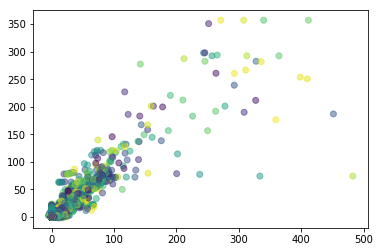

In [41]:
# YOUR CODE GOES HERE
import numpy as np
import matplotlib.pyplot as plt
colors = np.random.rand(X_train_level2.shape[0])
plt.scatter(X_train_level2[:,0], X_train_level2[:,1], c=colors, alpha=0.5)
plt.show()

In [67]:
alphas_to_try = np.linspace(0, 1, 1001)
r2_train = np.zeros([np.shape(alphas_to_try)[0],])
# YOUR CODE GOES HERE
index=0
for alpha in alphas_to_try:
    r2_train[index] = r2_score(y_train_level2.clip(0,20),(X_train_level2[:,0].clip(0,20)*alpha + X_train_level2[:,1].clip(0,20)*(1-alpha)))
    index += 1
best_alpha = alphas_to_try[np.argmax(r2_train)] # YOUR CODE GOES HERE
r2_train_simple_mix = r2_score(y_train_level2.clip(0,20),(X_train_level2[:,0].clip(0,20)*best_alpha + X_train_level2[:,1].clip(0,20)*(1-best_alpha))) # YOUR CODE GOES HERE

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.000000; Corresponding r2 score on train: 0.409477


In [83]:
alphas_to_try = np.linspace(0, 1, 1001)
rmse_train = np.zeros([np.shape(alphas_to_try)[0],])
# YOUR CODE GOES HERE
index=0
for alpha in alphas_to_try:
    rmse_train[index] = np.sqrt(np.sum((y_train_level2.clip(0,20)-(X_train_level2[:,0].clip(0,20)*alpha + X_train_level2[:,1].clip(0,20)*(1-alpha)))**2)/y_train_level2.shape[0])
    index += 1
best_alpha = alphas_to_try[np.argmin(rmse_train)] # YOUR CODE GOES HERE
rmse_train_simple_mix = np.sqrt(np.sum((y_train_level2.clip(0,20)-(X_train_level2[:,0].clip(0,20)*best_alpha + X_train_level2[:,1].clip(0,20)*(1-best_alpha)))**2)/y_train_level2.shape[0]) # YOUR CODE GOES HERE

print('Best alpha: %f; Corresponding rmse score on train: %f' % (best_alpha, rmse_train_simple_mix))

Best alpha: 0.000000; Corresponding rmse score on train: 0.820599


In [84]:
rmse_train

array([0.82059863, 0.82059887, 0.82059944, ..., 0.96866464, 0.96893872,
       0.96921299])

In [85]:
test_preds = pred_lr.clip(0,20)*best_alpha+pred_lgb.clip(0,20)*(1-best_alpha)# YOUR CODE GOES HERE
r2_test_simple_mix = r2_score(y_test.clip(0,20),test_preds.clip(0,20)) # YOUR CODE GOES HERE

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)
print('Test R-squared for single LGB is %f' % r2_score(y_test.clip(0,20), pred_lgb.clip(0,20)))

Test R-squared for simple mix is 0.352241
Test R-squared for single LGB is 0.352241


In [86]:
np.sqrt(np.sum((y_test.clip(0,20)-test_preds.clip(0,20))**2)/y_test.shape[0])

0.9144167633544937

In [ ]:
np.sqrt(np.sum((y_train_level2.clip(0,20)-(X_train_level2[:,0].clip(0,20)*alpha + X_train_level2[:,1].clip(0,20)*(1-alpha)))**2)/y_train_level2.shape[0])

## Stacking

In [142]:
# YOUR CODE GOES HERE
lr = LinearRegression()
lr.fit(X_train_level2, y_train_level2)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [148]:
train_preds = lr.predict(X_train_level2) # YOUR CODE GOES HERE
r2_train_stacking = r2_score(y_train_level2,train_preds)# YOUR CODE GOES HERE

X_test_level2 = np.c_[pred_lr, pred_lgb] 
test_preds = lr.predict(X_test_level2)# YOUR CODE GOES HERE
r2_test_stacking = r2_score(y_test,test_preds)# YOUR CODE GOES HERE

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)

Train R-squared for stacking is 0.276578
Test  R-squared for stacking is 0.349031


# Stacking: whole model

In [153]:
dates_train = dates


X_train = all_data.drop(to_drop_cols, axis=1)
X_test =  sub_test_data

y_train = all_data.loc[:, 'target'].values


In [154]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
sub_pred_lr = lr.predict(sub_test_data.values)

In [155]:
lgb_params = {
               'feature_fraction': 0.45,
               'metric': 'rmse',
               'nthread':11, 
               'min_data_in_leaf': 2**4, 
               'bagging_fraction': 0.84, 
               'learning_rate': 0.122, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**4,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
sub_pred_lgb = model.predict(sub_test_data)

In [156]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

In [157]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''  
    M=15
    X_train_m = X_train[dates_train.isin(list(range(27-M,cur_block_num)))]
    y_train_m = y_train[dates_train.isin(list(range(27-M,cur_block_num)))]
    X_test_m = X_train[dates_train==cur_block_num]
    lr = LinearRegression()
    lr.fit(X_train_m.values, y_train_m)
    pred_lr_train = lr.predict(X_test_m.values)
    
    lgb_params = {
               'feature_fraction': 0.45,
               'metric': 'rmse',
               'nthread':11, 
               'min_data_in_leaf': 2**4, 
               'bagging_fraction': 0.84, 
               'learning_rate': 0.122, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**4,
               'bagging_freq':1,
               'verbose':0 
              }

    model = lgb.train(lgb_params, lgb.Dataset(X_train_m, label=y_train_m), 100)
    pred_lgb_train = model.predict(X_test_m)
    
    index1 = dates_train.isin(list(range(27,cur_block_num+1))).sum()- (dates_train==cur_block_num).sum()
    index2 = dates_train.isin(list(range(27,cur_block_num+1))).sum()
    X_train_level2[index1:index2,0] = pred_lr_train
    X_train_level2[index1:index2,1] = pred_lgb_train
    #  YOUR CODE GOES HERE
    
    


27
28
29
30
31
32
33


In [158]:
# YOUR CODE GOES HERE
lr = LinearRegression()
lr.fit(X_train_level2, y_train_level2)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [160]:
X_test_level2 = np.c_[sub_pred_lr, sub_pred_lgb] 
sub_pred_stack = lr.predict(X_test_level2)# YOUR CODE GOES HERE


# Submission LGB

In [123]:
sub_test_data['item_cnt_month'] = sub_pred_lgb

In [124]:
test[['ID','shop_id','item_id']].head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [125]:
sub_test_data.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,...,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,item_cnt_month
6425094,5,5037,0.0,25.0,1052.0,1.0,110.0,1092.0,3.0,119.0,...,54.0,991.0,1.0,105.0,954.0,1.0,65.0,1445.0,19,0.383015
6425095,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.238589
6425096,5,5233,1.0,42.0,1052.0,3.0,80.0,1092.0,1.0,150.0,...,37.0,991.0,2.0,119.0,954.0,0.0,0.0,0.0,19,0.866186
6425097,5,5232,0.0,28.0,1052.0,0.0,48.0,1092.0,1.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.224132
6425098,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,2.459580


In [126]:
sub_file = sub_test_data.merge(test[['ID','shop_id','item_id']], on=['shop_id','item_id'], how='left')[['ID','item_cnt_month']]

In [127]:
sub_file["item_cnt_month"] = sub_file.item_cnt_month.fillna(0).clip(0, 20)

In [128]:
sub_file.to_csv('sample_submission1.csv',index=False)

# Submission: Stacking 

In [163]:
sub_test_data['item_cnt_month'] = sub_pred_stack
sub_file = sub_test_data.merge(test[['ID','shop_id','item_id']], on=['shop_id','item_id'], how='left')[['ID','item_cnt_month']]
sub_file["item_cnt_month"] = sub_file.item_cnt_month.fillna(0).clip(0, 20)
sub_file.to_csv('sample_submission1.csv',index=False)